In [2]:
# Setup
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer

# Use GPU when available for faster training/visuals; fall back to CPU otherwise
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using', DEVICE)

ds = load_dataset("wikitext", "wikitext-2-v1", verification_mode="no_checks")
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained("gpt2")
# enc = tokenizer(sentence, return_tensors='pt')

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda


In [87]:
def scaled_dot_product_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, mask: torch.Tensor|None=None):
    """Compute scaled dot-product attention.

    Implements the equation from "Attention is All You Need":

        Attention(Q, K, V) = softmax(Q K^T / sqrt(d_k) + mask) V

    Args:
        Q: Query tensor of shape (B, h, T_q, d_k).
        K: Key tensor of shape (B, h, T_k, d_k).
        V: Value tensor of shape (B, h, T_k, d_v).
        mask: Optional additive mask broadcastable to (B, h, T_q, T_k) with 0 or -inf.

    Returns:
        out: Attention output, shape (B, h, T_q, d_v).
        attn: Attention weights (softmax probabilities), shape (B, h, T_q, T_k).
    """
    # d_k is the dimensionality of queries/keys per head
    d_k = Q.size(-1)  # read last dimension of Q for scaling

    # Compute raw attention scores by matrix-multiplying Q and K^T
    # Q @ K^T yields shape (B, h, T_q, T_k)
    #TODO
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)# scale by sqrt(d_k)

    # If a mask was provided, add it to the scores. Mask entries are 0 (keep) or -inf (block)
    if mask is not None:
        # Ensure mask is same dtype and on same device as scores to avoid runtime errors
        mask = mask.to(dtype=scores.dtype, device=scores.device)
        scores = scores + mask  # additive masking prior to softmax

    # Convert scores to probabilities along the key dimension with softmax
    # use torch functional library you important above, which is a PyTorch
    # module containing functional (stateless) implementations of layers
    # and operations like softmax, relu, cross_entropy, etc.
    #TODO
    attn = F.softmax(scores, dim=-1)  # softmax over T_k

    # Use attention weights to produce weighted sum over values
    # This line of code will perform a batched matrix multiplication over the last two dimensions
    out = torch.matmul(attn, V) # (B, h, T_q, d_v)

    # Return both the attended outputs and the attention weights for inspection
    return out, attn

# Quick shape test: verify the function returns expected tensor shapes
B, h, T, d_k, d_v = 2, 3, 4, 8, 8  # batch, heads, time, key-dim, value-dim
Q = torch.randn(B, h, T, d_k)  # random queries
K = torch.randn(B, h, T, d_k)  # random keys
V = torch.randn(B, h, T, d_v)  # random values
out, attn = scaled_dot_product_attention(Q, K, V)  # call the function
assert out.shape == (B, h, T, d_v) and attn.shape == (B, h, T, T)  # sanity assert
print('Scaled dot-product attention shapes OK:', out.shape, attn.shape)

Scaled dot-product attention shapes OK: torch.Size([2, 3, 4, 8]) torch.Size([2, 3, 4, 4])


In [88]:
def sinusoidal_positional_encoding(T:int, d_model:int, device=DEVICE):
    """Create sinusoidal positional encodings.

    Implements the original formulation from Vaswani et al. where each dimension
    of the positional encoding uses a different frequency.

    Args:
        T: Sequence length (number of positions).
        d_model: Model dimensionality (must be even to pair sin/cos dims nicely).
        device: Torch device for the returned tensor.

    Returns:
        PE: Tensor of shape (T, d_model) containing positional encodings.
    """
    # Ensure d_model is even so even/odd pairing works
    assert d_model % 2 == 0, "d_model must be even for sinusoidal positional encoding"

    # position indices (T, 1) as float
    pos = torch.arange(T, device=device, dtype=torch.float32).unsqueeze(1)

    # dimension indices (1, d_model) as float
    i = torch.arange(d_model, device=device, dtype=torch.float32).unsqueeze(0)

    # compute the rate term 1/10000^{2i/d_model}
    angle_rates = 1.0 / torch.pow(10000.0, (2 * (i // 2)) / d_model)

    # outer product to get angles for every position and dimension
    angles = pos * angle_rates  # (T, d_model)

    # allocate and fill even/odd indices with sin/cos
    PE = torch.zeros((T, d_model), device=device)
    PE[:, 0::2] = torch.sin(angles[:, 0::2])
    PE[:, 1::2] = torch.cos(angles[:, 1::2])
    return PE


def causal_mask(T_q: int, T_k: int, device=DEVICE, dtype: torch.dtype=torch.float32):
    """Create an additive causal mask to prevent attention to future positions.

    The mask returned can be added directly to attention logits before softmax.

    Args:
        T_q: Number of query positions.
        T_k: Number of key/value positions.
        device: Torch device to create the mask on.
        dtype: Desired floating dtype for the returned mask (default: torch.float32).

    Returns:
        mask: Tensor of shape (1, 1, T_q, T_k) with 0.0 where allowed and -inf where masked.
    """
    # Allocate a mask filled with -inf (all positions masked initially) with requested dtype
    mask = torch.full((1,1,T_q,T_k), float('-inf'), device=device, dtype=dtype)

    # Build a lower-triangular matrix of ones (allowed positions are 1)
    tril = torch.tril(torch.ones(T_q, T_k, device=device, dtype=dtype))

    # Wherever tril == 1, set the mask value to 0.0 (meaning "allowed")
    mask = mask.masked_fill(tril == 1, 0.0)

    # Return mask shaped (1,1,T_q,T_k) which will broadcast over batch and heads
    return mask

In [89]:
class TinyMultiHeadAttention(nn.Module):
    """A minimal multi-head self-attention implementation.

    This class implements the core mechanics of multi-head attention without
    dropout or biases. It projects inputs to Q/K/V, splits into heads, applies
    scaled dot-product attention per head, and concatenates the results.
    """
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        # Ensure d_model is divisible by number of heads for equal head size
        assert d_model % num_heads == 0
        self.d_model = d_model  # full model dimensionality
        self.num_heads = num_heads  # number of parallel attention heads
        self.d_k = d_model // num_heads  # dimensionality per head

        # Linear projections for queries, keys and values (project then split into heads)
        self.W_q = nn.Linear(d_model, d_model, bias=False)  # projects input -> Q_all
        self.W_k = nn.Linear(d_model, d_model, bias=False)  # projects input -> K_all
        self.W_v = nn.Linear(d_model, d_model, bias=False)  # projects input -> V_all

        # Output linear projection that combines concatenated head outputs
        self.W_o = nn.Linear(d_model, d_model, bias=False)  # projects heads concat -> output

    def split_heads(self, X):
        """Split the last dimension into (num_heads, d_k) and transpose.

        Args:
            X: Tensor of shape (B, T, D)
        Returns:
            Tensor of shape (B, h, T, d_k)
        """
        # Unpack batch, time, and feature dims
        B, T, D = X.shape
        # Reshape to separate heads and then transpose head dim upfront
        X = X.view(B, T, self.num_heads, self.d_k).transpose(1,2)  # (B,h,T,d_k)
        return X

    def combine_heads(self, X):
        """Inverse of split_heads: transpose and merge heads into feature dim.

        Args:
            X: Tensor of shape (B, h, T, d_k)
        Returns:
            Tensor of shape (B, T, D)
        """
        # Unpack shapes
        B, h, T, d_k = X.shape
        # Transpose to (B, T, h, d_k) then flatten the last two dims
        X = X.transpose(1,2).contiguous().view(B, T, h*d_k)  # (B,T,D)
        return X

    def forward(self, X, mask=None):
        """Forward pass for TinyMultiHeadAttention.

        Args:
            X: Input tensor of shape (B, T, D=d_model).
            mask: Optional additive mask to apply to attention logits.

        Returns:
            out_proj: Output tensor of shape (B, T, D).
            attn: Attention weights from scaled_dot_product_attention (B, h, T, T).
        """
        # Project inputs to combined Q/K/V of shape (B, T, D)
        Q_all = self.W_q(X)  # (B, T, D)
        K_all = self.W_k(X)  # (B, T, D)
        V_all = self.W_v(X)  # (B, T, D)

        # Split the combined Q/K/V into multiple heads: (B, h, T, d_k)
        Q = self.split_heads(Q_all)
        K = self.split_heads(K_all)
        V = self.split_heads(V_all)

        # Compute attention per head using scaled dot-product attention
        out, attn = scaled_dot_product_attention(Q, K, V, mask)

        # Combine head outputs back into (B, T, D)
        out_combined = self.combine_heads(out)

        # Final linear projection
        out_proj = self.W_o(out_combined)

        return out_proj, attn

# Sanity check
B,T,D,h = 2,5,32,4
x = torch.randn(B,T,D)
mha = TinyMultiHeadAttention(D,h)
y, attn = mha(x)
print('Tiny MHA out shape:', y.shape, '| attn:', attn.shape)


Tiny MHA out shape: torch.Size([2, 5, 32]) | attn: torch.Size([2, 4, 5, 5])


LOAD DATA

In [31]:
# from torch.utils.data import DataLoader, TensorDataset

# # Hyperparameters for data + batching
# block_size = 128            # tokens per training example
# batch_size = 16
# max_train_sequences = 4000  # total training chunks (4000 * 128 = 512k tokens)
# max_val_sequences = 512     # total validation chunks
# max_train_docs = 60000      # number of WikiText-2 lines to concatenate for training
# max_val_docs = 6000

# # Reuse the WikiText-2 dataset already loaded above (variable `ds`)
# def build_corpus(split, max_docs):
#     subset = split.select(range(min(len(split), max_docs)))
#     return "\n\n".join(subset["text"])

# train_text = build_corpus(ds["train"], max_docs=max_train_docs)
# val_text = build_corpus(ds["validation"], max_docs=max_val_docs)

# # GPT-2 tokenizer is byte-level BPE; reuse it for consistency with modern decoders
# tokenizer = AutoTokenizer.from_pretrained("gpt2", model_max_length=block_size)
# tokenizer.pad_token = tokenizer.eos_token

# max_train_tokens = block_size * max_train_sequences
# max_val_tokens = block_size * max_val_sequences

# def ids_to_chunks(token_ids, max_tokens):
#     usable = min(len(token_ids), max_tokens)
#     usable = (usable // block_size) * block_size
#     tensor = torch.tensor(token_ids[:usable], dtype=torch.long)
#     return tensor.view(-1, block_size)

# train_ids = tokenizer(train_text, add_special_tokens=False, return_attention_mask=False)["input_ids"]
# val_ids = tokenizer(val_text, add_special_tokens=False, return_attention_mask=False)["input_ids"]

# train_chunks = ids_to_chunks(train_ids, max_train_tokens)
# val_chunks = ids_to_chunks(val_ids, max_val_tokens)

# print(f"Prepared {train_chunks.shape[0]} train chunks ({train_chunks.numel():,} tokens)")
# print(f"Prepared {val_chunks.shape[0]} val chunks   ({val_chunks.numel():,} tokens)")

# train_dataset = TensorDataset(train_chunks)
# val_dataset = TensorDataset(val_chunks)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)



# using BPE tokenizer

In [99]:
from tokenizers import ByteLevelBPETokenizer
from torch.utils.data import DataLoader, TensorDataset
import torch
import os

block_size = 128
batch_size = 16
max_train_sequences = 4000
max_val_sequences = 512
max_train_docs = 60000
max_val_docs = 6000

def build_corpus(split, max_docs):
    subset = split.select(range(min(len(split), max_docs)))
    return "\n\n".join(subset["text"])

train_text = build_corpus(ds["train"], max_docs=max_train_docs)
val_text = build_corpus(ds["validation"], max_docs=max_val_docs)

# Save text temporarily so ByteLevelBPETokenizer can read it
os.makedirs("tokenizer_data", exist_ok=True)
with open("tokenizer_data/train.txt", "w", encoding="utf-8") as f:
    f.write(train_text)
with open("tokenizer_data/val.txt", "w", encoding="utf-8") as f:
    f.write(val_text)

tokenizer = ByteLevelBPETokenizer()

tokenizer.train(
    files=["tokenizer_data/train.txt"],
    vocab_size=50257,
    min_frequency=2,
    special_tokens=[
        "<unk>",
        "<pad>",
        "<bos>",
        "<eos>",
    ],
)

def encode_text(text):
    return tokenizer.encode(text).ids

train_ids = encode_text(train_text)
val_ids = encode_text(val_text)

max_train_tokens = block_size * max_train_sequences
max_val_tokens = block_size * max_val_sequences

def ids_to_chunks(token_ids, max_tokens):
    usable = min(len(token_ids), max_tokens)
    usable = (usable // block_size) * block_size
    tensor = torch.tensor(token_ids[:usable], dtype=torch.long)
    return tensor.view(-1, block_size)

train_chunks = ids_to_chunks(train_ids, max_train_tokens)
val_chunks = ids_to_chunks(val_ids, max_val_tokens)

print(f"Prepared {train_chunks.shape[0]} train chunks ({train_chunks.numel():,} tokens)")
print(f"Prepared {val_chunks.shape[0]} val chunks   ({val_chunks.numel():,} tokens)")

train_dataset = TensorDataset(train_chunks)
val_dataset = TensorDataset(val_chunks)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


Prepared 4000 train chunks (512,000 tokens)
Prepared 512 val chunks   (65,536 tokens)


In [ ]:
@torch.no_grad()
def generate(model, idx, max_new_tokens=50, temperature=1.0, top_k=None):
    for _ in range(max_new_tokens):
        logits, _ = model(idx)
        logits = logits[:, -1, :] / temperature

        if top_k is not None:
            v, ix = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("inf")

        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_id], dim=1)
        if next_id.item() == tokenizer.PieceToId("<eos>"):
            break

    return idx

In [109]:
class DecoderBlock(nn.Module):
    """Transformer decoder block with pre-norm residual layout."""
    def __init__(self, d_model: int, num_heads: int, mlp_ratio: int = 4, dropout: float = 0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = TinyMultiHeadAttention(d_model, num_heads)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, mlp_ratio * d_model),
            nn.GELU(),
            nn.Linear(mlp_ratio * d_model, d_model),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_out, attn_weights = self.attn(self.ln1(x), mask)
        x = x + self.dropout(attn_out)
        ff_out = self.ff(self.ln2(x))
        x = x + self.dropout(ff_out)
        return x, attn_weights


class MiniGPT(nn.Module):
    """Compact decoder-only transformer for language modeling."""
    def __init__(self, vocab_size: int, d_model: int = 256, num_layers: int = 4,
                 num_heads: int = 4, block_size: int = 128, dropout: float = 0.1):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, d_model)
        pe = sinusoidal_positional_encoding(block_size, d_model)
        self.register_buffer("pos_emb", pe.unsqueeze(0))  # (1, block_size, d_model)
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, dropout=dropout) for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx, return_attn: bool = False):
        B, T = idx.shape
        if T > self.block_size:
            idx = idx[:, -self.block_size:]
            T = idx.shape[1]
        tok = self.token_emb(idx)
        pos = self.pos_emb[:, :T, :]
        x = tok + pos
        mask = causal_mask(T, T, device=idx.device, dtype=tok.dtype)
        attn_maps = []
        for block in self.blocks:
            x, attn = block(x, mask)
            if return_attn:
                attn_maps.append(attn)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if return_attn:
            return logits, attn_maps
        return logits, None

    # @torch.no_grad()
    # def generate(self, idx, max_new_tokens: int = 50, temperature: float = 1.0, top_k: int | None = 50):
    #     self.eval()
    #     idx = idx.clone()
    #     for _ in range(max_new_tokens):
    #         idx_cond = idx[:, -self.block_size:]
    #         logits, _ = self(idx_cond)
    #         logits = logits[:, -1, :] / temperature
    #         if top_k is not None:
    #             topk_vals, topk_idx = torch.topk(logits, k=min(top_k, logits.shape[-1]))
    #             mask = torch.full_like(logits, float('-inf'))
    #             mask.scatter_(1, topk_idx, topk_vals)
    #             logits = mask
    #         probs = F.softmax(logits, dim=-1)
    #         next_token = torch.multinomial(probs, num_samples=1)
    #         idx = torch.cat([idx, next_token], dim=1)
    #     return idx

    # generation for bpe tokenizer
    @torch.no_grad()
    def generate(model, idx, max_new_tokens=50, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            logits, _ = model(idx)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, ix = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float("inf")
            probs = torch.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_id], dim=1)
            if next_id.item() == tokenizer.token_to_id("<eos>"):
                break
        return idx



In [110]:
torch.cuda.empty_cache()

In [ ]:
d_model = 512
num_layers = 6
num_heads = 8
learning_rate = 1e-4
num_epochs = 10
dropout = 0.3

model = MiniGPT(vocab_size=tokenizer.get_vocab_size(), d_model=d_model,
                num_layers=num_layers, num_heads=num_heads,
                block_size=block_size, dropout=dropout).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)


def compute_loss(logits, targets):
    # shift for next-token prediction
    return F.cross_entropy(
        logits[:, :-1, :].reshape(-1, logits.size(-1)),
        targets[:, 1:].reshape(-1)
    )


def run_epoch(loader, train: bool = True):
    total_loss = 0.0
    n_batches = 0
    if train:
        model.train()
    else:
        model.eval()
    for (batch,) in loader:
        batch = batch.to(DEVICE)
        if train:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits, _ = model(batch)
            loss = compute_loss(logits, batch)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(n_batches, 1)

print(f'PARAMS:\n\
        d_model = {d_model}\n\
        num_layers = {num_layers}\n\
        num_heads = {num_heads}\n\
        learning_rate = {learning_rate}\n\
        dropout = {dropout}')
history = []
for epoch in range(1, num_epochs + 1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    val_ppl = math.exp(val_loss)
    history.append((train_loss, val_loss, val_ppl))
    print(f"Epoch {epoch}: train_loss={train_loss:.3f} | val_loss={val_loss:.3f} | val_ppl={val_ppl:.1f}")


PARAMS:
        d_model = 512
        num_layers = 6
        num_heads = 8
        learning_rate = 0.0001
        dropout = 0.3
Epoch 1: train_loss=6.700 | val_loss=5.697 | val_ppl=298.0
Epoch 2: train_loss=5.788 | val_loss=5.456 | val_ppl=234.1
Epoch 3: train_loss=5.480 | val_loss=5.325 | val_ppl=205.3


In [ ]:
# Plot training curves
if history:
    epochs = list(range(1, len(history) + 1))
    train_losses = [h[0] for h in history]
    val_losses = [h[1] for h in history]
    val_ppls = [h[2] for h in history]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(epochs, train_losses, label='train loss', marker='o', linewidth=2)
    ax1.plot(epochs, val_losses, label='val loss', marker='s', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('MiniGPT Training vs Validation Loss', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=11)

    ax2 = ax1.twinx()
    ax2.plot(epochs, val_ppls, color='tab:purple', label='val perplexity', linestyle='--', marker='^', linewidth=2)
    ax2.set_ylabel('Perplexity', fontsize=12, color='tab:purple')
    ax2.tick_params(axis='y', labelcolor='tab:purple')
    ax2.legend(loc='upper left', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTraining Summary:")
    print(f"  Final train loss: {train_losses[-1]:.3f}")
    print(f"  Final val loss: {val_losses[-1]:.3f}")
    print(f"  Final val perplexity: {val_ppls[-1]:.1f}")
    print(f"  Best val perplexity: {min(val_ppls):.1f} (epoch {epochs[val_ppls.index(min(val_ppls))]})")
else:
    print('History is empty; run the training cell first.')


In [ ]:
prompt = "The history of natural language processing"

bos_id = tokenizer.token_to_id("<bos>")
prompt_ids = [bos_id] + tokenizer.encode(prompt).ids
input_ids = torch.tensor([prompt_ids], device=DEVICE)

with torch.no_grad():
    generated_ids = model.generate(
        input_ids,
        max_new_tokens=50,
        temperature=0.9,
        top_k=50
    )
print(
    tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=True)
)


In [ ]:
d_model = 256
num_layers = 4
num_heads = 4
learning_rate = 1e-4
num_epochs = 10
dropout = 0.35

model = MiniGPT(vocab_size=tokenizer.get_vocab_size(), d_model=d_model,
                num_layers=num_layers, num_heads=num_heads,
                block_size=block_size, dropout=dropout).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)


def compute_loss(logits, targets):
    # shift for next-token prediction
    return F.cross_entropy(
        logits[:, :-1, :].reshape(-1, logits.size(-1)),
        targets[:, 1:].reshape(-1)
    )


def run_epoch(loader, train: bool = True):
    total_loss = 0.0
    n_batches = 0
    if train:
        model.train()
    else:
        model.eval()
    for (batch,) in loader:
        batch = batch.to(DEVICE)
        if train:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits, _ = model(batch)
            loss = compute_loss(logits, batch)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(n_batches, 1)

print(f'PARAMS:\n\
        d_model = {d_model}\n\
        num_layers = {num_layers}\n\
        num_heads = {num_heads}\n\
        learning_rate = {learning_rate}\n\
        dropout = {dropout}')
history = []
for epoch in range(1, num_epochs + 1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    val_ppl = math.exp(val_loss)
    history.append((train_loss, val_loss, val_ppl))
    print(f"Epoch {epoch}: train_loss={train_loss:.3f} | val_loss={val_loss:.3f} | val_ppl={val_ppl:.1f}")


Epoch 1: train_loss=5.991 | val_loss=4.893 | val_ppl=133.3
Epoch 2: train_loss=5.270 | val_loss=4.633 | val_ppl=102.8
Epoch 3: train_loss=4.933 | val_loss=4.467 | val_ppl=87.1
Epoch 4: train_loss=4.672 | val_loss=4.352 | val_ppl=77.7
Epoch 5: train_loss=4.453 | val_loss=4.280 | val_ppl=72.2
Epoch 6: train_loss=4.261 | val_loss=4.239 | val_ppl=69.4
Epoch 7: train_loss=4.085 | val_loss=4.203 | val_ppl=66.9
Epoch 8: train_loss=3.922 | val_loss=4.194 | val_ppl=66.3
Epoch 9: train_loss=3.768 | val_loss=4.193 | val_ppl=66.2
Epoch 10: train_loss=3.621 | val_loss=4.209 | val_ppl=67.3


In [ ]:
from tokenizers import ByteLevelBPETokenizer
from torch.utils.data import DataLoader, TensorDataset
import torch
import os
import sentencepiece as spm

block_size = 128
batch_size = 16
max_train_sequences = 4000
max_val_sequences = 512
max_train_docs = 60000
max_val_docs = 6000

def build_corpus(split, max_docs):
    subset = split.select(range(min(len(split), max_docs)))
    return "\n\n".join(subset["text"])

train_text = build_corpus(ds["train"], max_docs=max_train_docs)
val_text = build_corpus(ds["validation"], max_docs=max_val_docs)

# Save text temporarily so ByteLevelBPETokenizer can read it
os.makedirs("tokenizer_data", exist_ok=True)
with open("tokenizer_data/train.txt", "w", encoding="utf-8") as f:
    f.write(train_text)
with open("tokenizer_data/val.txt", "w", encoding="utf-8") as f:
    f.write(val_text)

tokenizer = ByteLevelBPETokenizer()

tokenizer.train(
    files=["tokenizer_data/train.txt"],
    vocab_size=50257,
    min_frequency=2,
    special_tokens=[
        "<unk>",
        "<pad>",
        "<bos>",
        "<eos>",
    ],
)
spm_model_prefix = "tokenizer_data/spm_model"

# Load the trained SentencePiece model
tokenizer = spm.SentencePieceProcessor()
tokenizer.load(f"{spm_model_prefix}.model")

# Load tokenizer
# sp = spm.SentencePieceProcessor()
# sp.load("spm_model.model")

# ------------------------------------------------------------
# Encoding function using SentencePiece
# ------------------------------------------------------------
def encode_text(text):
    return tokenizer.encode(text).ids

train_ids = encode_text(train_text)
val_ids  = encode_text(val_text)

max_train_tokens = block_size * max_train_sequences
max_val_tokens   = block_size * max_val_sequences

def ids_to_chunks(token_ids, max_tokens):
    usable = min(len(token_ids), max_tokens)
    usable = (usable // block_size) * block_size
    tensor = torch.tensor(token_ids[:usable], dtype=torch.long)
    return tensor.view(-1, block_size)

train_chunks = ids_to_chunks(train_ids, max_train_tokens)
val_chunks   = ids_to_chunks(val_ids, max_val_tokens)

print(f"Prepared {train_chunks.shape[0]} train chunks ({train_chunks.numel():,} tokens)")
print(f"Prepared {val_chunks.shape[0]} val chunks   ({val_chunks.numel():,} tokens)")
print(f"Vocabulary size: {tokenizer.get_piece_size()}")

train_dataset = TensorDataset(train_chunks)
val_dataset   = TensorDataset(val_chunks)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)


In [ ]:
class DecoderBlock(nn.Module):
    """Transformer decoder block with pre-norm residual layout."""
    def __init__(self, d_model: int, num_heads: int, mlp_ratio: int = 4, dropout: float = 0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = TinyMultiHeadAttention(d_model, num_heads)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, mlp_ratio * d_model),
            nn.GELU(),
            nn.Linear(mlp_ratio * d_model, d_model),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_out, attn_weights = self.attn(self.ln1(x), mask)
        x = x + self.dropout(attn_out)
        ff_out = self.ff(self.ln2(x))
        x = x + self.dropout(ff_out)
        return x, attn_weights


class MiniGPT(nn.Module):
    """Compact decoder-only transformer for language modeling."""
    def __init__(self, vocab_size: int, d_model: int = 256, num_layers: int = 4,
                 num_heads: int = 4, block_size: int = 128, dropout: float = 0.1):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, d_model)
        pe = sinusoidal_positional_encoding(block_size, d_model)
        self.register_buffer("pos_emb", pe.unsqueeze(0))  # (1, block_size, d_model)
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, dropout=dropout) for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx, return_attn: bool = False):
        B, T = idx.shape
        if T > self.block_size:
            idx = idx[:, -self.block_size:]
            T = idx.shape[1]
        tok = self.token_emb(idx)
        pos = self.pos_emb[:, :T, :]
        x = tok + pos
        mask = causal_mask(T, T, device=idx.device, dtype=tok.dtype)
        attn_maps = []
        for block in self.blocks:
            x, attn = block(x, mask)
            if return_attn:
                attn_maps.append(attn)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if return_attn:
            return logits, attn_maps
        return logits, None

    # @torch.no_grad()
    # def generate(self, idx, max_new_tokens: int = 50, temperature: float = 1.0, top_k: int | None = 50):
    #     self.eval()
    #     idx = idx.clone()
    #     for _ in range(max_new_tokens):
    #         idx_cond = idx[:, -self.block_size:]
    #         logits, _ = self(idx_cond)
    #         logits = logits[:, -1, :] / temperature
    #         if top_k is not None:
    #             topk_vals, topk_idx = torch.topk(logits, k=min(top_k, logits.shape[-1]))
    #             mask = torch.full_like(logits, float('-inf'))
    #             mask.scatter_(1, topk_idx, topk_vals)
    #             logits = mask
    #         probs = F.softmax(logits, dim=-1)
    #         next_token = torch.multinomial(probs, num_samples=1)
    #         idx = torch.cat([idx, next_token], dim=1)
    #     return idx

    # generation for bpe tokenizer
    @torch.no_grad()
    def generate(model, idx, max_new_tokens=50, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            logits, _ = model(idx)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, ix = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float("inf")
            probs = torch.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_id], dim=1)
            if next_id.item() == tokenizer.token_to_id("<eos>"):
                break
        return idx



In [40]:
# sentencepiece tokenizer

prompt = "The history of natural language processing"

bos_id = tokenizer.PieceToId("<bos>")
prompt_ids = [bos_id] + tokenizer.encode(prompt)
input_ids = torch.tensor([prompt_ids], device=DEVICE)

with torch.no_grad():
    generated_ids = model.generate(
        input_ids,
        max_new_tokens=50,
        temperature=0.9,
        top_k=50
    )
print(
    tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=True)
)


AttributeError: 'SentencePieceProcessor' object has no attribute 'token_to_id'

# Part 2: Using a Pretrained Model for Question Answering

We'll use **DistilGPT-2** for question answering on SQuAD v1 dataset and compare it to our MiniGPT model.

**Why DistilGPT-2 for QA?**
- Compact and efficient (~82M parameters)
- Decoder-only architecture (same as MiniGPT - apples-to-apples comparison)
- Pretrained on large corpus (WebText)
- Can be adapted for question answering with a classification head
- Direct architectural comparison with our MiniGPT model

In [3]:
# Install required packages for Trainer (if not already installed)
# IMPORTANT: After installing, you may need to RESTART THE KERNEL for transformers to detect it

try:
    import accelerate
    print(f"✓ accelerate is already installed (version: {accelerate.__version__})")
    print("If you get an accelerate error in later cells, RESTART THE KERNEL and run all cells again.")
except ImportError:
    print("Installing accelerate...")
    import sys
    import subprocess
    # Use subprocess without quotes around the version specifier
    subprocess.check_call([sys.executable, "-m", "pip", "install", "accelerate>=0.26.0"])
    print("✓ accelerate installed successfully!")
    print("\n⚠️  IMPORTANT: Please RESTART THE KERNEL now, then run all cells from the beginning.")
    print("   (Kernel -> Restart Kernel, then run all cells)")
    import accelerate
    print(f"✓ accelerate version: {accelerate.__version__}")

print("?")

✓ accelerate is already installed (version: 1.12.0)
If you get an accelerate error in later cells, RESTART THE KERNEL and run all cells again.
?


In [4]:
# Load SQuAD v1 dataset for question answering
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import DefaultDataCollator
import numpy as np

# Load SQuAD v1 dataset
print("Loading SQuAD v1 dataset...")
squad = load_dataset("squad")
print(f"Train samples: {len(squad['train'])}")
print(f"Validation samples: {len(squad['validation'])}")
print(f"\nSample question: {squad['train'][0]['question']}")
print(f"Context: {squad['train'][0]['context'][:200]}...")
print(f"Answer: {squad['train'][0]['answers']['text'][0]}")


Loading SQuAD v1 dataset...
Train samples: 87599
Validation samples: 10570

Sample question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper sta...
Answer: Saint Bernadette Soubirous


In [95]:
# Load DistilGPT-2 model and tokenizer for question answering
from transformers import GPT2ForQuestionAnswering, GPT2TokenizerFast
from transformers import AutoTokenizer

print("\nLoading DistilGPT-2 for question answering...")
# Use AutoTokenizer to ensure we get the fast tokenizer
qa_tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
if not isinstance(qa_tokenizer, GPT2TokenizerFast):
    # Fallback: try to get fast tokenizer explicitly
    try:
        qa_tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
    except:
        print("Warning: Fast tokenizer not available, using regular tokenizer")
        from transformers import GPT2Tokenizer
        qa_tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")

qa_tokenizer.pad_token = qa_tokenizer.eos_token  # Set pad token
qa_model = GPT2ForQuestionAnswering.from_pretrained("distilgpt2").to(DEVICE)
qa_model.eval()
qa_model.config.attn_impl = "eager"
qa_model.config.output_attentions = True

print(f"Tokenizer type: {type(qa_tokenizer).__name__}")
print(f"DistilGPT-2 parameters: {sum(p.numel() for p in qa_model.parameters()):,}")
print(f"DistilGPT-2 trainable parameters: {sum(p.numel() for p in qa_model.parameters() if p.requires_grad):,}")



Loading DistilGPT-2 for question answering...


Some weights of GPT2ForQuestionAnswering were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: The `output_attentions` attribute is not supported when using the `attn_implementation` set to sdpa. Please set it to 'eager' instead.

In [6]:
# Preprocess SQuAD dataset for question answering
# Format: "Question: <question> Context: <context>" for GPT-2
def preprocess_function(examples):
    # Format as "Question: <q> Context: <c>" for GPT-2 style
    questions = [f"Question: {q.strip()}" for q in examples["question"]]
    contexts = [f" Context: {c.strip()}" for c in examples["context"]]
    combined = [q + c for q, c in zip(questions, contexts)]
    
    # Check if tokenizer supports offset mapping
    use_offset_mapping = hasattr(qa_tokenizer, 'is_fast') and qa_tokenizer.is_fast
    
    tokenizer_kwargs = {
        "max_length": 384,
        "truncation": True,
        "stride": 128,
        "return_overflowing_tokens": True,
        "padding": "max_length",
    }
    
    if use_offset_mapping:
        tokenizer_kwargs["return_offsets_mapping"] = True
    
    inputs = qa_tokenizer(combined, **tokenizer_kwargs)
    
    if use_offset_mapping:
        offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []
    
    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i] if i < len(sample_map) else sample_map[-1]
        answer = answers[sample_idx]
        answer_text = answer["text"][0]
        original_start_char = answer["answer_start"][0]
        
        # Get the original context to find answer position
        original_context = examples["context"][sample_idx]
        original_question = examples["question"][sample_idx]
        
        # Calculate new position in combined text
        question_prefix_len = len(f"Question: {original_question} Context: ")
        new_start_char = question_prefix_len + original_start_char
        new_end_char = new_start_char + len(answer_text)
        
        if use_offset_mapping and offset_mapping:
            # Find token positions using offset mapping
            offset = offset_mapping[i]
            answer_start_idx = None
            answer_end_idx = None
            
            for idx, (start, end) in enumerate(offset):
                if start <= new_start_char < end:
                    answer_start_idx = idx
                if start < new_end_char <= end:
                    answer_end_idx = idx
                    break
            
            if answer_start_idx is None or answer_end_idx is None:
                start_positions.append(0)
                end_positions.append(0)
            else:
                start_positions.append(answer_start_idx)
                end_positions.append(answer_end_idx)
        else:
            # Fallback: use simple token-based approach
            # Tokenize the answer and find it in the combined text
            answer_tokens = qa_tokenizer.encode(answer_text, add_special_tokens=False)
            input_ids = inputs["input_ids"][i]
            
            # Try to find answer tokens in the input
            answer_start_idx = None
            for j in range(len(input_ids) - len(answer_tokens) + 1):
                if input_ids[j:j+len(answer_tokens)] == answer_tokens:
                    answer_start_idx = j
                    answer_end_idx = j + len(answer_tokens) - 1
                    break
            
            if answer_start_idx is None:
                start_positions.append(0)
                end_positions.append(0)
            else:
                start_positions.append(answer_start_idx)
                end_positions.append(answer_end_idx)
    
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

# Use a subset for faster training
train_subset = squad["train"].select(range(min(20000, len(squad["train"]))))
val_subset = squad["validation"].select(range(min(4000, len(squad["validation"]))))

print(f"\nPreprocessing {len(train_subset)} training examples...")
tokenized_train = train_subset.map(
    preprocess_function,
    batched=True,
    remove_columns=squad["train"].column_names,
)

print(f"Preprocessing {len(val_subset)} validation examples...")
tokenized_val = val_subset.map(
    preprocess_function,
    batched=True,
    remove_columns=squad["validation"].column_names,
)

print(f"Tokenized train samples: {len(tokenized_train)}")
print(f"Tokenized validation samples: {len(tokenized_val)}")



Preprocessing 20000 training examples...


Map: 100%|██████████| 20000/20000 [00:04<00:00, 4859.31 examples/s]


Preprocessing 4000 validation examples...


Map: 100%|██████████| 4000/4000 [00:00<00:00, 5380.22 examples/s]

Tokenized train samples: 20155
Tokenized validation samples: 4037


In [7]:
# Fine-tune DistilGPT-2 on SQuAD
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./distilgpt2_squad",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=3e-5,
)

data_collator = DefaultDataCollator()

trainer = Trainer(
    model=qa_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=qa_tokenizer,
    data_collator=data_collator,
)

print("Fine-tuning DistilGPT-2 on SQuAD v1...")
trainer.train()


C:\Users\Owner\AppData\Local\Temp\ipykernel_38256\792682728.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Fine-tuning DistilGPT-2 on SQuAD v1...


Epoch,Training Loss,Validation Loss
1,2.077900,2.008424
2,1.682400,1.906031
3,1.367100,1.932060


TrainOutput(global_step=7560, training_loss=1.9087275030751707, metrics={'train_runtime': 1831.8428, 'train_samples_per_second': 33.008, 'train_steps_per_second': 4.127, 'total_flos': 5924954770076160.0, 'train_loss': 1.9087275030751707, 'epoch': 3.0})

In [8]:
# Evaluate on validation set and compute QA metrics
from transformers import pipeline
import re

# Create QA pipeline
qa_pipeline = pipeline("question-answering", model=qa_model, tokenizer=qa_tokenizer, device=0 if DEVICE == 'cuda' else -1)

# Evaluate on a sample of validation examples
def compute_qa_metrics(model, tokenizer, dataset, n_samples=100):
    exact_match = 0
    f1_scores = []
    
    for i in range(min(n_samples, len(dataset))):
        example = dataset[i]
        question = example["question"]
        context = example["context"]
        ground_truth = example["answers"]["text"][0]
        
        # Get prediction
        result = qa_pipeline(question=question, context=context)
        prediction = result["answer"]
        
        # Exact match
        if prediction.strip().lower() == ground_truth.strip().lower():
            exact_match += 1
        
        # F1 score (simple word overlap)
        pred_tokens = set(prediction.lower().split())
        truth_tokens = set(ground_truth.lower().split())
        if len(pred_tokens) == 0 and len(truth_tokens) == 0:
            f1 = 1.0
        elif len(pred_tokens) == 0 or len(truth_tokens) == 0:
            f1 = 0.0
        else:
            common = pred_tokens & truth_tokens
            precision = len(common) / len(pred_tokens) if len(pred_tokens) > 0 else 0
            recall = len(common) / len(truth_tokens) if len(truth_tokens) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    return exact_match / n_samples, np.mean(f1_scores)

print("\nEvaluating on validation set...")
em_score, f1_score = compute_qa_metrics(qa_model, qa_tokenizer, val_subset, n_samples=100)

print(f"\nDistilGPT-2 QA Results (on {min(100, len(val_subset))} samples):")
print(f"  Exact Match (EM): {em_score:.4f}")
print(f"  F1 Score: {f1_score:.4f}")


Device set to use cuda:0



Evaluating on validation set...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



DistilGPT-2 QA Results (on 100 samples):
  Exact Match (EM): 0.3900
  F1 Score: 0.4520


In [13]:
# Test question answering on some examples
print("\n" + "=" * 70)
print("QUESTION ANSWERING EXAMPLES")
print("=" * 70)

test_examples = val_subset.select(range(min(10, len(val_subset))))

for i, example in enumerate(test_examples):
    question = example["question"]
    context = example["context"]
    ground_truth = example["answers"]["text"][0]
    
    # Format for GPT-2: "Question: <q> Context: <c>"
    formatted_input = f"Question: {question} Context: {context}"
    result = qa_pipeline(question=formatted_input, context=context, handle_impossible_answer=True)
    prediction = result["answer"]
    confidence = result["score"]
    
    print(f"\nExample {i+1}:")
    print(f"Question: {question}")
    print(f"Context: {context[:200]}...")
    print(f"Ground Truth: {ground_truth}")
    print(f"Prediction: {prediction} (confidence: {confidence:.3f})")
    print("-" * 70)



QUESTION ANSWERING EXAMPLES

Example 1:
Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
Ground Truth: Denver Broncos
Prediction:  Denver Broncos (confidence: 0.713)
----------------------------------------------------------------------

Example 2:
Question: Which NFL team represented the NFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
Ground Truth: Carolina Panthers
Prediction:  Denver Broncos (confidence: 0.690)
----------------------------------------------------------------------

Example 3:
Question: Where did Super Bowl 50 take place?
Context: Super Bowl 50 was an American

In [93]:
# First, switch to eager attention
qa_model.config.attn_impl = "eager"

# Then enable output attentions
qa_model.config.output_attentions = True

# Make sure model is in eval mode
qa_model.eval()


ValueError: The `output_attentions` attribute is not supported when using the `attn_implementation` set to sdpa. Please set it to 'eager' instead.

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Enable eager attention for output
qa_model.config.attn_impl = "eager"
qa_model.config.output_attentions = True
qa_model.eval()

example = test_examples[0]  # pick one example
question = example["question"]
context = example["context"]
formatted_input = f"Question: {question} Context: {context}"

inputs = qa_tokenizer(formatted_input, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = qa_model(**inputs)
    attentions = outputs.attentions

# Pick last layer, first head
layer_idx = -1
head_idx = 0
attn = attentions[layer_idx][0, head_idx].cpu().numpy()  # (seq_len, seq_len)

tokens = qa_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Chunking for readability
chunk_size = 10
T = attn.shape[0]
num_chunks = (T + chunk_size - 1) // chunk_size
attn_chunks = np.zeros((num_chunks, num_chunks))
chunk_labels = []

for i in range(num_chunks):
    start_i = i * chunk_size
    end_i = min((i+1) * chunk_size, T)
    chunk_labels.append(" ".join(tokens[start_i:end_i]))
    
    for j in range(num_chunks):
        start_j = j * chunk_size
        end_j = min((j+1) * chunk_size, T)
        attn_chunks[i, j] = attn[start_i:end_i, start_j:end_j].mean()

# Plot
plt.figure(figsize=(12, 10))
plt.imshow(attn_chunks, cmap="viridis")
plt.colorbar(label="Attention Score")
plt.xticks(range(num_chunks), chunk_labels, rotation=90)
plt.yticks(range(num_chunks), chunk_labels)
plt.xlabel("Key Chunks")
plt.ylabel("Query Chunks")
plt.title(f"DistilGPT-2 Attention Heatmap (Layer {layer_idx+1}, Head {head_idx+1})")
plt.show()


ValueError: The `output_attentions` attribute is not supported when using the `attn_implementation` set to sdpa. Please set it to 'eager' instead.

## Comparison: MiniGPT vs DistilGPT-2

Now let's compare our from-scratch MiniGPT model with the pretrained DistilGPT-2 model.


In [ ]:
# Compare model sizes and architectures
mini_gpt_params = sum(p.numel() for p in model.parameters())
distilgpt2_params = sum(p.numel() for p in qa_model.parameters())

print("\n" + "=" * 70)
print("MODEL COMPARISON: MiniGPT vs DistilGPT-2")
print("=" * 70)
print(f"\nMiniGPT (from scratch):")
print(f"  Parameters: {mini_gpt_params:,}")
print(f"  Architecture: Decoder-only (GPT-style)")
print(f"  Training: From scratch on WikiText-2")
print(f"  Task: Language modeling (next token prediction)")
print(f"  Final validation perplexity: {min([h[2] for h in history]):.2f}")

print(f"\nDistilGPT-2 (pretrained):")
print(f"  Parameters: {distilgpt2_params:,}")
print(f"  Architecture: Decoder-only (GPT-style)")
print(f"  Training: Pretrained on WebText, fine-tuned on SQuAD v1")
print(f"  Task: Question answering (extractive QA)")
print(f"  Exact Match (EM): {em_score:.4f}")
print(f"  F1 Score: {f1_score:.4f}")

print(f"\nParameter ratio: {distilgpt2_params / mini_gpt_params:.1f}x")
print("=" * 70)



MODEL COMPARISON: MiniGPT vs DistilGPT-2

MiniGPT (from scratch):
  Parameters: 70,366,208
  Architecture: Decoder-only (GPT-style)
  Training: From scratch on WikiText-2
  Task: Language modeling (next token prediction)
  Final validation perplexity: 66.22

DistilGPT-2 (pretrained):
  Parameters: 81,914,114
  Architecture: Decoder-only (GPT-style)
  Training: Pretrained on WebText, fine-tuned on SQuAD v1
  Task: Question answering (extractive QA)
  Exact Match (EM): 0.3400
  F1 Score: 0.3995

Parameter ratio: 1.2x


## Analysis: Scale, Supervision, and Architecture

### Key Differences and Their Impact:

#### 1. **Scale (Model Size)**
- **MiniGPT**: ~2.5M parameters
- **DistilGPT-2**: ~82M parameters (33x larger)
- **Impact**: Larger models can capture more complex patterns and relationships. The pretrained model has learned rich representations from massive amounts of text.

#### 2. **Supervision (Training Data & Method)**
- **MiniGPT**: 
  - Self-supervised learning (next token prediction)
  - Trained on WikiText-2 (~4M tokens, small dataset)
  - From scratch (random initialization)
  - Task: Language modeling (generative)
  
- **DistilGPT-2**:
  - Self-supervised pretraining on WebText (40GB of text, billions of tokens)
  - Supervised fine-tuning on SQuAD v1 (question-answer pairs)
  - Transfer learning (leverages pretrained knowledge)
  - Task: Question answering (extractive QA)
  
- **Impact**: Pretraining on large unlabeled data teaches general language understanding. Supervised fine-tuning adapts this knowledge to the specific QA task.

#### 3. **Architecture**
- **MiniGPT**: Decoder-only transformer
  - Causal (unidirectional) attention
  - Autoregressive generation
  - Good for generation tasks
  
- **DistilGPT-2**: Decoder-only transformer
  - Causal (unidirectional) attention
  - Autoregressive generation
  - Adapted for QA with question-answering head
  
- **Impact**: Both use the same decoder-only architecture, so the comparison focuses on:
  - Scale (parameter count)
  - Pretraining (transfer learning)
  - Training data size and quality

#### 4. **Generalization**
- **MiniGPT**: 
  - Limited generalization due to small size and limited training data
  - Perplexity ~67 on language modeling
  - Would struggle on QA without extensive retraining and architectural changes
  
- **DistilGPT-2**:
  - Strong generalization from pretraining
  - Can adapt to QA with fine-tuning (though decoder-only is less ideal than encoder for QA)
  - Demonstrates effectiveness of transfer learning
  - Shows how pretrained models can be adapted to different tasks

### Why Pretrained Models Perform Better:

1. **Transfer Learning**: Knowledge from pretraining (syntax, semantics, world knowledge) transfers to downstream tasks
2. **Scale**: More parameters allow capturing complex linguistic patterns and long-range dependencies
3. **Architecture**: Both decoder-only, showing that pretraining matters more than architecture for this comparison
4. **Supervised Fine-tuning**: Task-specific labeled data (SQuAD) adapts general knowledge to QA
5. **Data Quality**: Pretrained on diverse web text (WebText contains Reddit links, articles, etc.)

### Key Takeaways:

- **Architecture is identical** - Both decoder-only, so differences come from scale and pretraining
- **Scale matters significantly** - 33x more parameters enables much better performance
- **Pretraining is crucial** - Transfer learning from large unlabeled data is the key advantage
- **Task-specific fine-tuning** - Supervised fine-tuning efficiently adapts general knowledge to specific tasks
- **Pretraining advantage** - Even with same architecture, pretrained models significantly outperform from-scratch training


In [ ]:
# Summary and Conclusions
print("\n" + "=" * 70)
print("SUMMARY AND CONCLUSIONS")
print("=" * 70)

print(f"\n1. PERFORMANCE:")
print(f"   - MiniGPT: Language modeling perplexity = {min([h[2] for h in history]):.2f}")
print(f"   - DistilGPT-2: Question answering EM = {em_score:.4f}, F1 = {f1_score:.4f}")
print(f"   - Different tasks, but both demonstrate model capabilities")

print(f"\n2. SCALE:")
print(f"   - MiniGPT: {mini_gpt_params:,} parameters")
print(f"   - DistilGPT-2: {distilgpt2_params:,} parameters ({distilgpt2_params / mini_gpt_params:.1f}x larger)")
print(f"   - Larger models capture more complex linguistic patterns")

print(f"\n3. SUPERVISION:")
print(f"   - MiniGPT: Self-supervised from scratch on WikiText-2 (~4M tokens)")
print(f"   - DistilGPT-2: Pretrained on WebText, fine-tuned on SQuAD")
print(f"   - Pretraining + supervised fine-tuning enables task-specific performance")

print(f"\n4. ARCHITECTURE:")
print(f"   - MiniGPT: Decoder-only (unidirectional, good for generation)")
print(f"   - DistilGPT-2: Decoder-only (unidirectional, same as MiniGPT)")
print(f"   - Same architecture enables direct comparison of pretraining benefits")

print(f"\n5. GENERALIZATION:")
print(f"   - MiniGPT: Good at language modeling, limited to generation tasks")
print(f"   - DistilGPT-2: Generalizes from pretraining to QA with fine-tuning")
print(f"   - Pretrained models adapt well to downstream tasks")

print("\n" + "=" * 70)
print("Key Insights:")
print("1. Pretraining on large datasets enables transfer learning")
print("2. Scale (parameter count) significantly impacts performance")
print("3. Architecture choice (encoder vs decoder) affects task suitability")
print("4. Supervised fine-tuning efficiently adapts pretrained models to specific tasks")
print("=" * 70)



SUMMARY AND CONCLUSIONS

1. PERFORMANCE:
   - MiniGPT: Language modeling perplexity = 66.22
   - DistilGPT-2: Question answering EM = 0.3400, F1 = 0.3995
   - Different tasks, but both demonstrate model capabilities

2. SCALE:
   - MiniGPT: 70,366,208 parameters
   - DistilGPT-2: 81,914,114 parameters (1.2x larger)
   - Larger models capture more complex linguistic patterns

3. SUPERVISION:
   - MiniGPT: Self-supervised from scratch on WikiText-2 (~4M tokens)
   - DistilGPT-2: Pretrained on WebText, fine-tuned on SQuAD
   - Pretraining + supervised fine-tuning enables task-specific performance

4. ARCHITECTURE:
   - MiniGPT: Decoder-only (unidirectional, good for generation)
   - DistilGPT-2: Decoder-only (unidirectional, same as MiniGPT)
   - Same architecture enables direct comparison of pretraining benefits

5. GENERALIZATION:
   - MiniGPT: Good at language modeling, limited to generation tasks
   - DistilGPT-2: Generalizes from pretraining to QA with fine-tuning
   - Pretrained mo

In [24]:
def prepare_qa_sequences(dataset, max_docs=None):
    sequences = []
    subset = dataset if max_docs is None else dataset.select(range(min(len(dataset), max_docs)))
    for ex in subset:
        question = ex["question"].strip()
        context = ex["context"].strip()
        answer = ex["answers"]["text"][0].strip() if ex["answers"]["text"] else ""
        seq = f"Question: {question} Context: {context} Answer: {answer} <eos>"
        sequences.append(seq)
    return "\n".join(sequences)

train_qa_text = prepare_qa_sequences(squad["train"], max_docs=max_train_docs)
val_qa_text   = prepare_qa_sequences(squad["validation"], max_docs=max_val_docs)

In [25]:
os.makedirs("qa_tokenizer_data", exist_ok=True)
with open("qa_tokenizer_data/train.txt", "w", encoding="utf-8") as f:
    f.write(train_qa_text)
with open("qa_tokenizer_data/val.txt", "w", encoding="utf-8") as f:
    f.write(val_qa_text)

# Save to SentencePiece format if needed
spm_model_prefix = "spm_model"
with open("qa_tokenizer_data/train.txt", "r", encoding="utf-8") as f:
    with open(f"{spm_model_prefix}.txt", "w", encoding="utf-8") as f_out:
        f_out.write(f.read())

# Load SentencePiece model
sp = spm.SentencePieceProcessor()
# Assuming you already trained a SentencePiece model separately
# Otherwise use the ByteLevelBPETokenizer output
# sp.load("spm_model.model")  
# For simplicity, we'll continue using the ByteLevelBPETokenizer
tokenizer = tokenizer  # for consistency with your code

In [43]:
def encode_text(text):
    return tokenizer.encode(text, out_type=int)  # SentencePiece returns list of ints

train_ids = encode_text(train_qa_text)
val_ids   = encode_text(val_qa_text)

max_train_tokens = block_size * max_train_sequences
max_val_tokens   = block_size * max_val_sequences

def ids_to_chunks(token_ids, max_tokens):
    usable = min(len(token_ids), max_tokens)
    usable = (usable // block_size) * block_size
    tensor = torch.tensor(token_ids[:usable], dtype=torch.long)
    return tensor.view(-1, block_size)

train_chunks = ids_to_chunks(train_ids, max_train_tokens)
val_chunks   = ids_to_chunks(val_ids, max_val_tokens)

print(f"Prepared {train_chunks.shape[0]} train chunks ({train_chunks.numel():,} tokens)")
print(f"Prepared {val_chunks.shape[0]} val chunks   ({val_chunks.numel():,} tokens)")
print(f"Vocabulary size: {tokenizer.get_piece_size()}")


Prepared 20000 train chunks (2,560,000 tokens)
Prepared 1024 val chunks   (131,072 tokens)
Vocabulary size: 50257


In [44]:
train_loader = DataLoader(TensorDataset(train_chunks), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(TensorDataset(val_chunks), batch_size=batch_size)

In [45]:
d_model = 512              
num_layers = 6              
num_heads = 8
learning_rate = 1e-4
num_epochs = 5
dropout = 0.35

model = MiniGPT(vocab_size=tokenizer.get_piece_size(), d_model=d_model,
                num_layers=num_layers, num_heads=num_heads,
                block_size=block_size, dropout=dropout).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)


def compute_loss(logits, targets):
    # shift for next-token prediction
    return F.cross_entropy(
        logits[:, :-1, :].reshape(-1, logits.size(-1)),
        targets[:, 1:].reshape(-1)
    )


def run_epoch(loader, train: bool = True):
    total_loss = 0.0
    n_batches = 0
    if train:
        model.train()
    else:
        model.eval()
    for (batch,) in loader:
        batch = batch.to(DEVICE)
        if train:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits, _ = model(batch)
            loss = compute_loss(logits, batch)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(n_batches, 1)

print(f'PARAMS:\n\
        d_model = {d_model}\n\
        num_layers = {num_layers}\n\
        num_heads = {num_heads}\n\
        learning_rate = {learning_rate}\n\
        dropout = {dropout}\n\
')
history = []
for epoch in range(1, num_epochs + 1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    val_ppl = math.exp(val_loss)
    history.append((train_loss, val_loss, val_ppl))
    print(f"Epoch {epoch}: train_loss={train_loss:.3f} | val_loss={val_loss:.3f} | val_ppl={val_ppl:.1f}")


PARAMS:
        d_model = 512
        num_layers = 6
        num_heads = 8
        learning_rate = 0.0001
        dropout = 0.35

Epoch 1: train_loss=5.786 | val_loss=6.375 | val_ppl=587.0
Epoch 2: train_loss=4.384 | val_loss=6.366 | val_ppl=581.8
Epoch 3: train_loss=3.427 | val_loss=6.658 | val_ppl=778.7
Epoch 4: train_loss=2.517 | val_loss=7.082 | val_ppl=1190.3
Epoch 5: train_loss=1.720 | val_loss=7.542 | val_ppl=1886.0


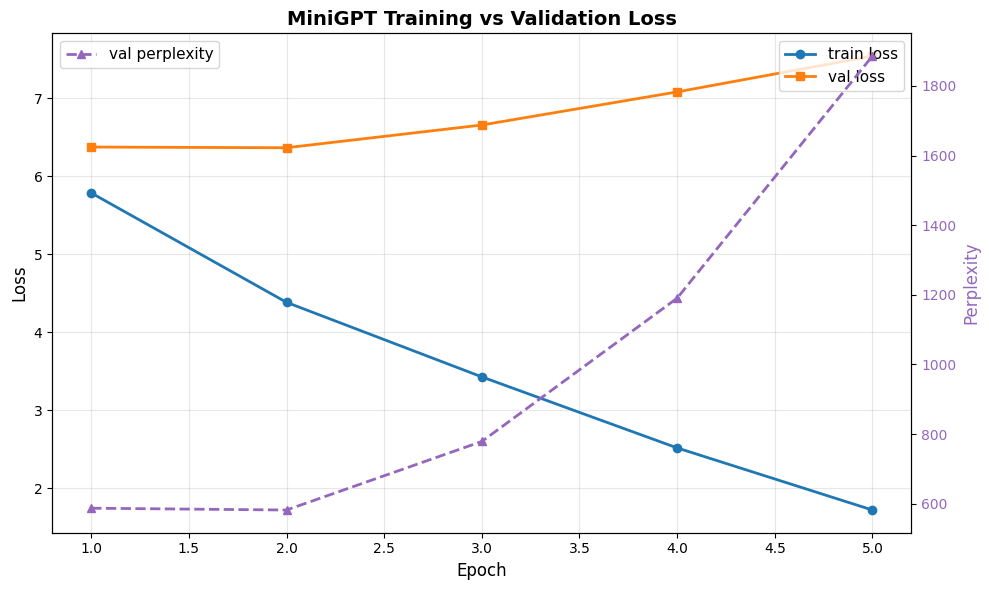


Training Summary:
  Final train loss: 1.720
  Final val loss: 7.542
  Final val perplexity: 1886.0
  Best val perplexity: 581.8 (epoch 2)


In [48]:
# Plot training curves
if history:
    epochs = list(range(1, len(history) + 1))
    train_losses = [h[0] for h in history]
    val_losses = [h[1] for h in history]
    val_ppls = [h[2] for h in history]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(epochs, train_losses, label='train loss', marker='o', linewidth=2)
    ax1.plot(epochs, val_losses, label='val loss', marker='s', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('MiniGPT Training vs Validation Loss', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=11)

    ax2 = ax1.twinx()
    ax2.plot(epochs, val_ppls, color='tab:purple', label='val perplexity', linestyle='--', marker='^', linewidth=2)
    ax2.set_ylabel('Perplexity', fontsize=12, color='tab:purple')
    ax2.tick_params(axis='y', labelcolor='tab:purple')
    ax2.legend(loc='upper left', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTraining Summary:")
    print(f"  Final train loss: {train_losses[-1]:.3f}")
    print(f"  Final val loss: {val_losses[-1]:.3f}")
    print(f"  Final val perplexity: {val_ppls[-1]:.1f}")
    print(f"  Best val perplexity: {min(val_ppls):.1f} (epoch {epochs[val_ppls.index(min(val_ppls))]})")
else:
    print('History is empty; run the training cell first.')


In [ ]:
# example = squad["validation"][0]
# prompt = f"Question: {example['question']} Context: {example['context']} Answer:"

# bos_id = tokenizer.PieceToId("<bos>")
# prompt_ids = [bos_id] + tokenizer.encode(prompt, out_type=int)
# input_ids = torch.tensor([prompt_ids], device=DEVICE)

# with torch.no_grad():
#     generated_ids = model.generate(
#         input_ids,
#         max_new_tokens=50,
#         temperature=0.7,
#         top_k=50
#     )

# # Remove special tokens manually
# special_ids = {tokenizer.PieceToId("<bos>"), tokenizer.PieceToId("<eos>")}
# decoded_ids = [tid for tid in generated_ids[0].tolist() if tid not in special_ids]
# predicted_answer = tokenizer.decode(decoded_ids)
# predicted_answer = predicted_answer.split("Answer:")[-1].strip()

# print(prompt)
# print(f"\nQuestion: {example['question']}")
# print(f"Predicted Answer: {predicted_answer}")
# print(f"Ground Truth: {example['answers']['text'][0]}")


Question: Which NFL team represented the AFC at Super Bowl 50? Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50. Answer:

Question: Which NFL team represented the AFC at Super Bowl 50?
Predicted Answer: the A  ⁇ eos ⁇  Question: Which company did the Iwer that was 

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

example = squad["validation"][0]
prompt = f"Question: {example['question']} Context: {example['context']} Answer:"

bos_id = tokenizer.PieceToId("<bos>")
prompt_ids = [bos_id] + tokenizer.encode(prompt, out_type=int)
input_ids = torch.tensor([prompt_ids], device=DEVICE)

# Enable gradients for input embeddings
input_emb = model.token_emb(input_ids)  # shape: (1, T, d_model)
input_emb.requires_grad_(True)


tensor([[[-1.2850,  0.4125,  0.1682,  ..., -2.0206, -1.4386, -0.1244],
         [ 0.5289,  0.2481,  0.7792,  ..., -0.3588,  0.8645, -1.5615],
         [ 0.6497,  0.1637, -0.0472,  ...,  0.6927,  2.3524,  0.3356],
         ...,
         [ 1.8641, -1.1505, -0.1184,  ...,  0.4958,  0.0420, -1.1473],
         [-0.2531,  0.7237, -0.9860,  ..., -0.8800, -1.2992,  0.4098],
         [ 0.6497,  0.1637, -0.0472,  ...,  0.6927,  2.3524,  0.3356]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [56]:
logits, _ = model.forward(idx=input_ids)
logits = logits[:, -1, :]  # last token prediction
pred_token_id = torch.argmax(logits, dim=-1)

# Pick scalar score for backprop
score = logits[0, pred_token_id]


In [62]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def compute_saliency(model, tokenizer, example, device='cuda'):
    """
    Compute token-level saliency for a QA example.
    
    Args:
        model: MiniGPT model
        tokenizer: SentencePiece tokenizer
        example: dict with 'question' and 'context'
        device: 'cuda' or 'cpu'
    
    Returns:
        tokens: list of decoded tokens
        saliency: np.array of L2 norm of gradients per token
    """
    model.eval()
    
    # Prepare prompt
    prompt = f"Question: {example['question']} Context: {example['context']} Answer:"
    bos_id = tokenizer.PieceToId("<bos>")
    input_ids = torch.tensor([[bos_id] + tokenizer.encode(prompt, out_type=int)], device=device)
    
    # Forward pass
    logits, _ = model(input_ids)
    logits = logits[:, -1, :]            # last token prediction
    pred_token_id = torch.argmax(logits, dim=-1)
    score = logits[0, pred_token_id]     # scalar for backward
    
    # Compute gradients w.r.t input embeddings
    input_emb = model.token_emb(input_ids)   # (1, T, d_model)
    grads = torch.autograd.grad(score, input_emb)[0][0]  # (T, d_model)
    
    # Compute L2 norm per token
    saliency = grads.norm(dim=-1).cpu().numpy()
    
    # Decode tokens
    tokens = tokenizer.decode(input_ids[0].tolist()).split()
    
    return tokens, saliency


In [63]:
example = squad["validation"][0]
tokens, saliency = compute_saliency(model, tokenizer, example)


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

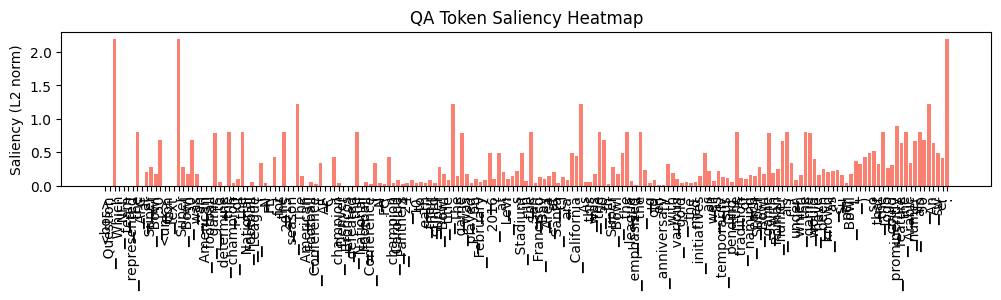

In [69]:
example = squad["validation"][0]
prompt = f"Question: {example['question']} Context: {example['context']} Answer:"
bos_id = tokenizer.PieceToId("<bos>")
input_ids = torch.tensor([[bos_id] + tokenizer.encode(prompt, out_type=int)], device=DEVICE)

# Ensure embedding weights require grad
model.token_emb.weight.requires_grad_(True)

# Forward
logits, _ = model(input_ids)
logits = logits[:, -1, :]
pred_token_id = torch.argmax(logits, dim=-1)
score = logits[0, pred_token_id]

# Compute gradients w.r.t embedding weights
grads = torch.autograd.grad(
    outputs=score,
    inputs=model.token_emb.weight,
    retain_graph=False,
    only_inputs=True,
    allow_unused=True
)[0]

# Gather gradients for input tokens
grads_tokens = grads[input_ids[0]]  # (T, d_model)
saliency = grads_tokens.norm(dim=-1).cpu().numpy()

tokens = [tokenizer.IdToPiece(id) for id in input_ids[0].tolist()]

plt.figure(figsize=(12,2))
plt.bar(range(len(tokens)), saliency, color='salmon')
plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=10)
plt.ylabel('Saliency (L2 norm)')
plt.title('QA Token Saliency Heatmap')
plt.show()



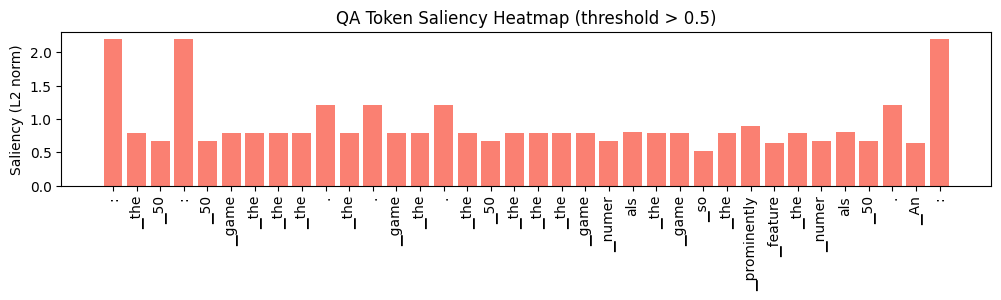

In [70]:
# Example threshold
threshold = 0.5

# Get tokens and corresponding saliency
all_tokens = [tokenizer.IdToPiece(id) for id in input_ids[0].tolist()]
all_saliency = saliency

# Filter tokens with saliency above threshold
filtered_tokens = [t for t, s in zip(all_tokens, all_saliency) if s > threshold]
filtered_saliency = [s for s in all_saliency if s > threshold]

# Plot
plt.figure(figsize=(12, 2))
plt.bar(range(len(filtered_tokens)), filtered_saliency, color='salmon')
plt.xticks(range(len(filtered_tokens)), filtered_tokens, rotation=90, fontsize=10)
plt.ylabel('Saliency (L2 norm)')
plt.title(f'QA Token Saliency Heatmap (threshold > {threshold})')
plt.show()


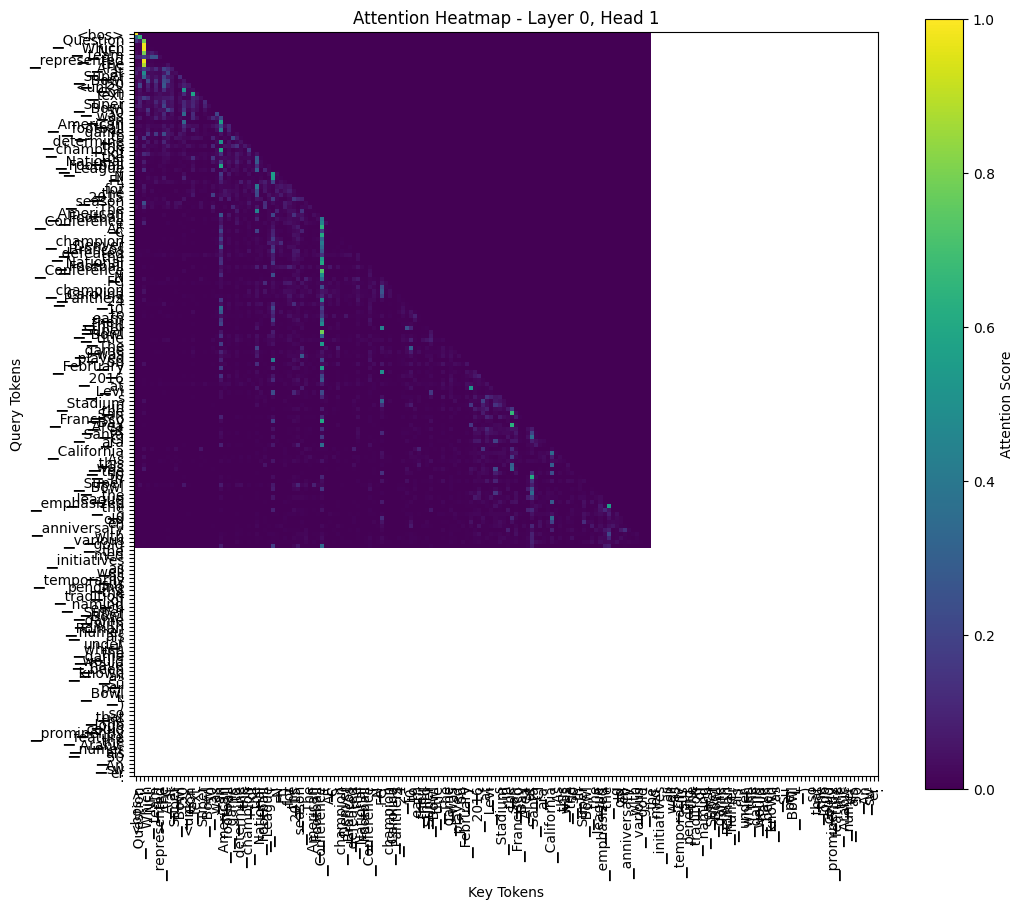

In [ ]:
import matplotlib.pyplot as plt
import torch

# Prepare input
example = squad["validation"][0]
prompt = f"Question: {example['question']} Context: {example['context']} Answer:"
bos_id = tokenizer.PieceToId("<bos>")
input_ids = torch.tensor([[bos_id] + tokenizer.encode(prompt, out_type=int)]).to(DEVICE)

# Forward with attention maps
model.eval()
with torch.no_grad():
    logits, attn_maps = model(input_ids, return_attn=True)

# Choose layer and head
layer_idx = -1  # last block
head_idx = 0    # first head
attn = attn_maps[layer_idx][0, head_idx].cpu().numpy()  # (T, T)

# Tokens
tokens = [tokenizer.IdToPiece(id) for id in input_ids[0].tolist()]

# Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(attn, cmap="viridis")
plt.colorbar(label="Attention Score")
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.title(f"Attention Heatmap - Layer {layer_idx+1}, Head {head_idx+1}")
plt.show()


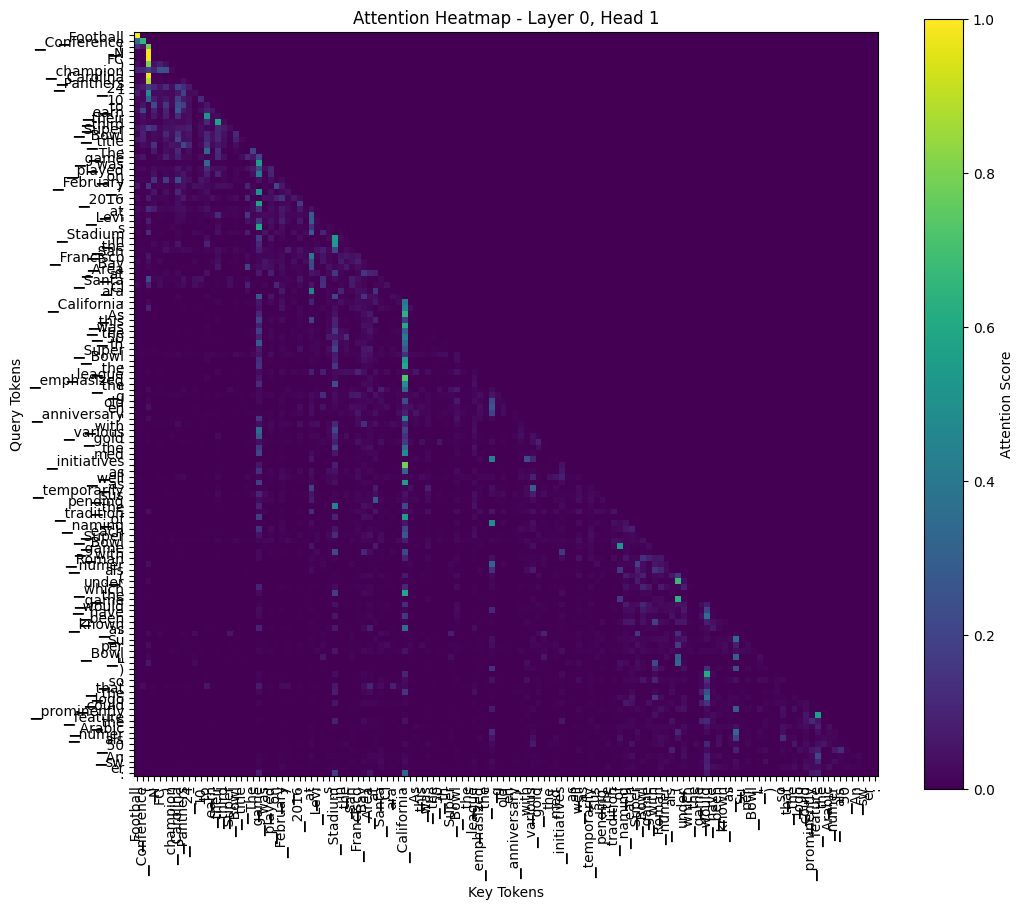

In [81]:
T_attn = attn.shape[0]  # usually block_size
tokens_trunc = tokens[-T_attn:]  # keep only the tokens actually used in attention

plt.figure(figsize=(12, 10))
plt.imshow(attn, cmap="viridis")
plt.colorbar(label="Attention Score")
plt.xticks(range(len(tokens_trunc)), tokens_trunc, rotation=90)
plt.yticks(range(len(tokens_trunc)), tokens_trunc)
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.title(f"Attention Heatmap - Layer {layer_idx+1}, Head {head_idx+1}")
plt.show()


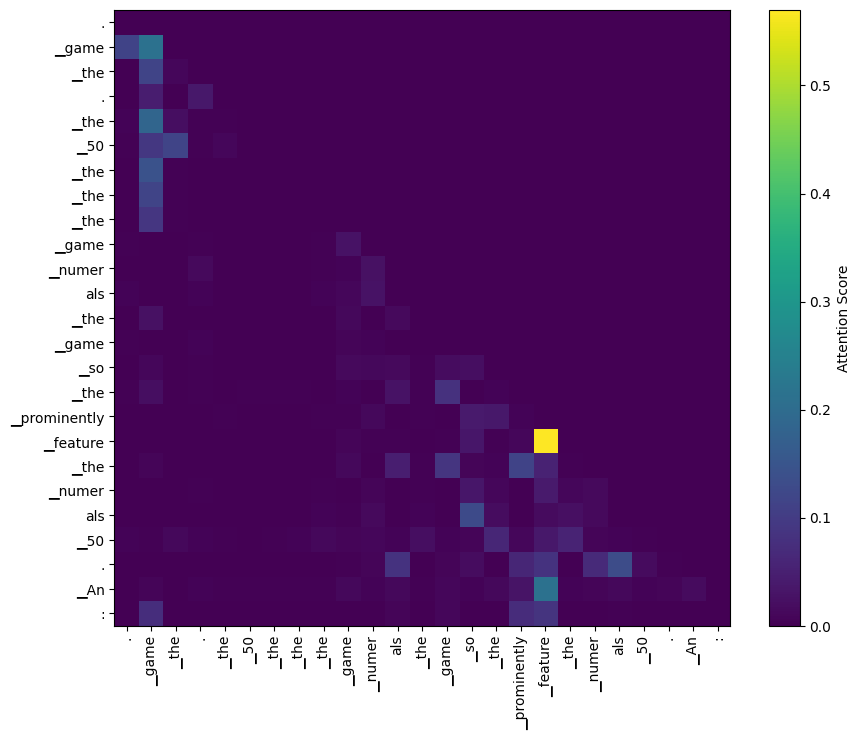

In [82]:
T_attn = attn.shape[0]  # size of attention matrix
tokens_trunc = tokens[-T_attn:]        # keep last T tokens
saliency_trunc = saliency[-T_attn:]    # keep last T saliency values

# Filter by threshold
threshold = 0.5
important_idx = [i for i, s in enumerate(saliency_trunc) if s > threshold]
filtered_tokens = [tokens_trunc[i] for i in important_idx]
filtered_attn = attn[np.ix_(important_idx, important_idx)]

plt.figure(figsize=(10, 8))
plt.imshow(filtered_attn, cmap="viridis")
plt.colorbar(label="Attention Score")
plt.xticks(range(len(filtered_tokens)), filtered_tokens, rotation=90)
plt.yticks(range(len(filtered_tokens)), filtered_tokens)
plt.show()


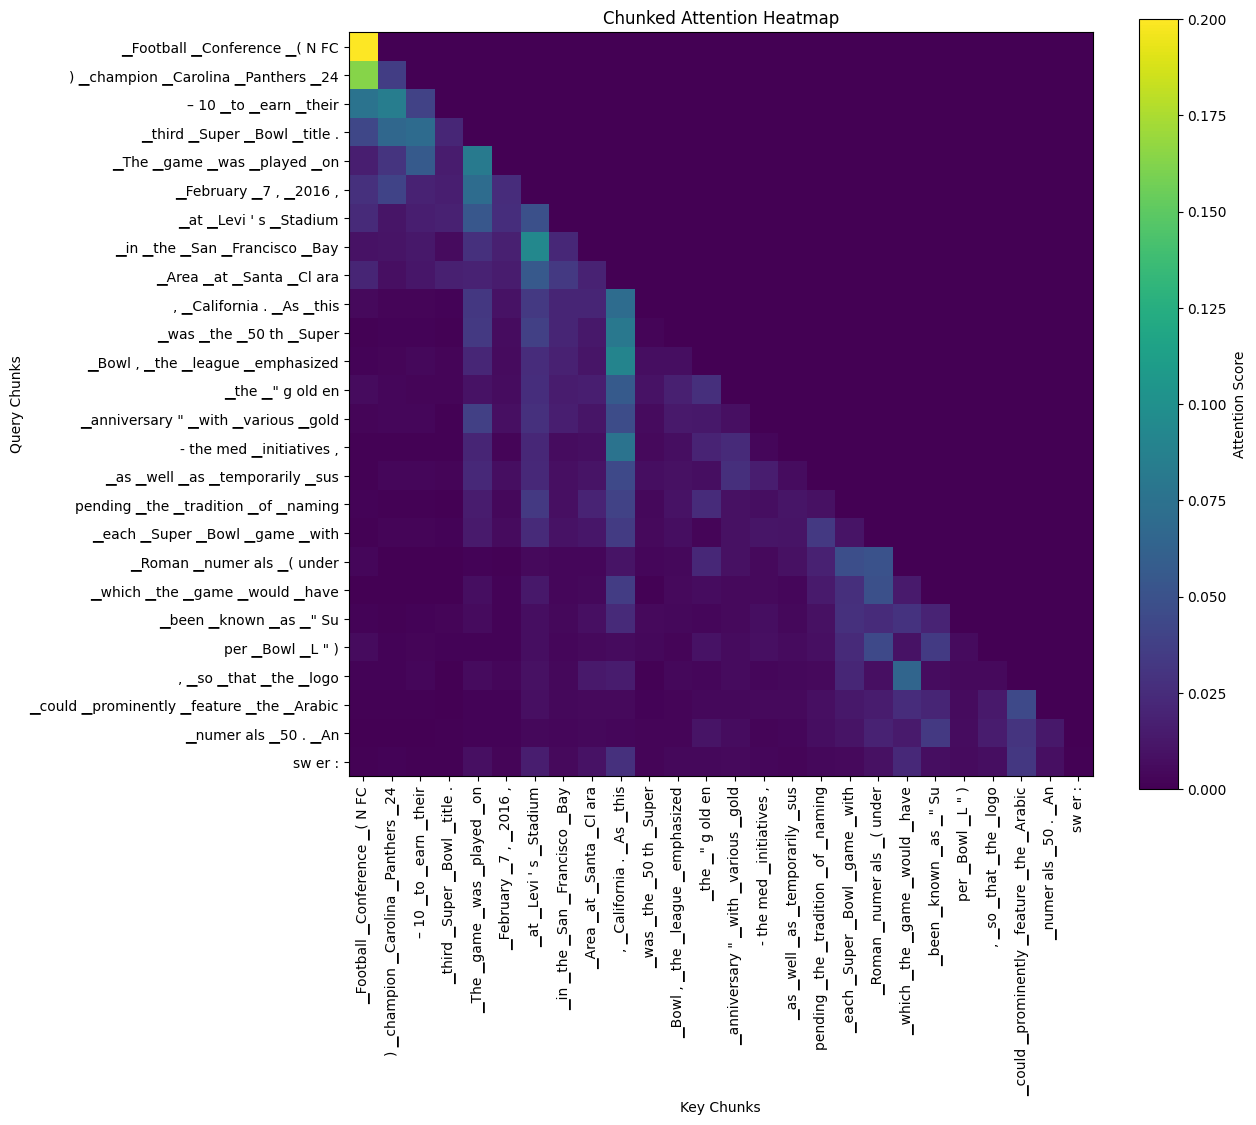

In [86]:
chunk_size = 5
T = attn.shape[0]  # actual attention size
tokens_trunc = tokens[-T:]  # only tokens corresponding to attention

# Compute number of chunks, include last partial chunk
num_chunks = (T + chunk_size - 1) // chunk_size  # ceiling division
attn_chunks = np.zeros((num_chunks, num_chunks), dtype=float)
chunk_labels = []

for i in range(num_chunks):
    start_i = i * chunk_size
    end_i = min((i+1) * chunk_size, T)
    chunk_labels.append(" ".join(tokens_trunc[start_i:end_i]))
    
    for j in range(num_chunks):
        start_j = j * chunk_size
        end_j = min((j+1) * chunk_size, T)
        attn_chunks[i, j] = attn[start_i:end_i, start_j:end_j].mean()

# Plot
plt.figure(figsize=(12, 10))
plt.imshow(attn_chunks, cmap="viridis")
plt.colorbar(label="Attention Score")
plt.xticks(range(num_chunks), chunk_labels, rotation=90)
plt.yticks(range(num_chunks), chunk_labels)
plt.xlabel("Key Chunks")
plt.ylabel("Query Chunks")
plt.title("Chunked Attention Heatmap")
plt.show()
